In [1]:
from functools import partial

from common.conics import plot_conics, ConicProjector, ellipse_axes, scale_det, conic_center
from common.coordinates import ENU_system
from src.matching import CraterDatabase, CoplanarInvariants
from src.common.data import DataGenerator
from src.detection.metrics import gaussian_angle_distance
import src.common.constants as const
import numpy as np
import numpy.linalg as LA
from sklearn.linear_model import RANSACRegressor
from src.matching.position_estimation import derive_position


import matplotlib.pyplot as plt

In [2]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv",
                              latlims=(0, 20),
                              longlims=(0, 20),
                              diamlims=(7, 40)
                              )
gen = DataGenerator.from_robbins_dataset(file_path="../data/lunar_crater_database_robbins_2018.csv", diamlims=(7, 40), axis_threshold=(1, 250))
gen.set_coordinates(10, 10, 250, convert_to_radians=True)
gen.position

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


array([[1927.18160338],
       [ 339.8141134 ],
       [ 345.05629384]])

In [3]:
A_detections = gen.craters_in_image()
crater_triads_, key = next(CoplanarInvariants.match_generator(
    A_craters=A_detections,
    max_iter=1,
    batch_size=1000
))
top_n = 1

A_db_ = np.repeat(A_detections[crater_triads_.ravel()], top_n, axis=0)

match_idxs, dist = map(lambda x: x.reshape(-1), db.query(key, k=top_n, return_distance=True))

r_query_, C_query_ = db[match_idxs]
r_query_, C_query_ = r_query_.reshape(-1, 3, 1), C_query_.reshape(-1, 3, 3)
_, unique_mapping = np.unique(match_idxs, return_index=True)
dist_filter = dist.ravel()[unique_mapping] < 100

A_db, r_query, C_query = map(lambda x: x[unique_mapping][dist_filter], (A_db_, r_query_, C_query_))
A_db.shape, r_query.shape, C_query.shape

((501, 3, 3), (501, 3, 1), (501, 3, 3))

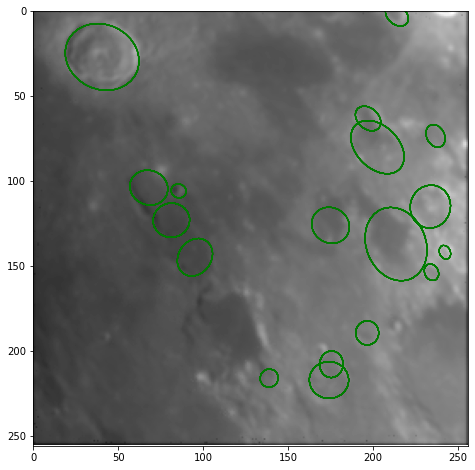

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(gen.generate_image(), cmap='gray')
gen.plot(ax=ax)
plot_conics(A_db, ax=ax, rim_color='green')

In [2]:
k = np.array([0., 0., 1.])[:, None]
S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)

T = gen.T
K = gen.K

B_craters = T @ K.T @ A_db @ K @ LA.inv(T)
T_EM = np.concatenate(ENU_system(r_query), axis=-1)
T_ME = LA.inv(T_EM)

A_ = S.T @ T_ME @ B_craters
A = A_.reshape(-1, 3)
b_ = S.T @ T_ME @ B_craters @ r_query
b = b_.reshape(-1, 1)

def model_validator_(model, *args, min_alt=10, max_alt=1000, primary_body_radius=const.RMOON):
    return (primary_body_radius + min_alt) < LA.norm(model.coef_) < (primary_body_radius + max_alt)

min_inliers = int(len(A_db)/top_n/8)

ransac = RANSACRegressor(residual_threshold=1, stop_n_inliers=min_inliers, max_trials=100000, loss='squared_loss', is_model_valid=model_validator_)
ransac.fit(A, b)

inlier_mask = np.logical_and.reduce(ransac.inlier_mask_.reshape(b_.shape), axis=(-1, -2))
num_inliers = inlier_mask.sum()
est_pos = ransac.estimator_.coef_.T
if num_inliers >= ransac.stop_n_inliers:
    print(f"Match found! Position error: {LA.norm(est_pos - gen.position):.2f} km | Inliers: {num_inliers}")
else:
    print("No match found")

NameError: name 'np' is not defined

In [6]:
C_inlier, r_inlier = C_query.reshape(-1, 3, 3)[inlier_mask], r_query.reshape(-1, 3, 1)[inlier_mask]

projector = ConicProjector(position=est_pos, attitude=gen.T)

A_projected = projector.project_crater_conics(C_inlier, r_inlier)
A_matched = A_db[inlier_mask]

In [7]:
sigma_pix = 3
primary_body_radius = const.RMOON
max_alt = 500

divergence = gaussian_angle_distance(A_projected, A_matched)

a_i, b_i = ellipse_axes(A_projected)

sigma = (0.85 / np.sqrt(a_i * b_i)) * sigma_pix

reprojection_mask = ((divergence / sigma) ** 2) <= 13.276
gen.position - derive_position(A_craters=A_matched[reprojection_mask], r_craters=r_inlier[reprojection_mask], T=gen.T, K=gen.K, min_inliers=10)

C:\dev\workspace\crater-detection\src\detection\metrics.py:232: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(frac_term * exp_term)


array([[-1.36424205e-12],
       [-1.13686838e-13],
       [-5.68434189e-14]])

In [3]:
est_pos2, num_matches = db.query_position(A_detections, T=T, K=K, max_trials=1000)
est_pos2 - gen.position

NameError: name 'db' is not defined

In [9]:
reprojection_mask


array([ True,  True, False, False,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True, False,  True, False,  True, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False,  True, False, False, False, False,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
       False, False,  True,  True,  True,  True,  True, False, False,
       False,  True,  True, False, False, False, False,  True, False,
       False, False,  True,  True, False,  True,  True, False, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True, False, False, False, False,  True, False])